# notes on fitting

I'm building a velocity-depth trend and I need the resulting trendline to be anchored to the velocity aorund the sea bottom, otherwise I may end up with some crazy ass trends.

I have found a solution on [stackexchange](http://stackoverflow.com/questions/15191088/how-to-do-a-polynomial-fit-with-fixed-points) but I wonder if there's anything simpler (and that I may be able to actually understand).

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

This is the function that does the magic (taken from 
<http://stackoverflow.com/questions/15191088/how-to-do-a-polynomial-fit-with-fixed-points>):

In [33]:
def solve_ns(A, b): return np.linalg.solve(np.dot(A.T, A), np.dot(A.T, b))
def clsq(A, b, C, d):
    """An 'exact' constrained least squared solution of Ax= b, s.t. Cx= d"""
    from scipy.linalg import qr
    p= C.shape[0]
    Q, R= qr(C.T)
    xr, AQ= np.linalg.solve(R[:p].T, d), np.dot(A, Q)
    xaq= solve_ns(AQ[:, p:], b- np.dot(AQ[:, :p], xr))
    return np.dot(Q[:, :p], xr)+ np.dot(Q[:, p:], xaq)
def cpf(x, y, x_c, y_c, n):
    """Constrained polynomial fit based on clsq solution."""
    from numpy.polynomial.polynomial import Polynomial as P, polyvander as V
    return P(clsq(V(x, n), y, V(x_c, n), y_c))

An example on how to use it.

Let's pretend that the water depth is 200m and that the velocity of the first meters of sediments is 1600 m/s. This pair of points will be our 'anchor'.

In [34]:
L=pd.read_csv('qsiwell2.csv')

vp=L.VP.values
z=L.DEPTH.values
mask = np.isfinite(vp) # mask to select valid (i.e., not NaNs) velocity samples

z0 = np.array([1000]) # anchor point
vp0 = np.array([1600])

zfit = np.linspace(z0,3000,100)
degree = 1

fit0 = np.polyfit(z[mask],vp[mask],degree)
trend = np.polyval(fit0,zfit)

fit1 = cpf(z[mask], vp[mask], z0 , vp0, degree)

Plots the velocity log with the two trendlines and the anchor point at the seabottom:

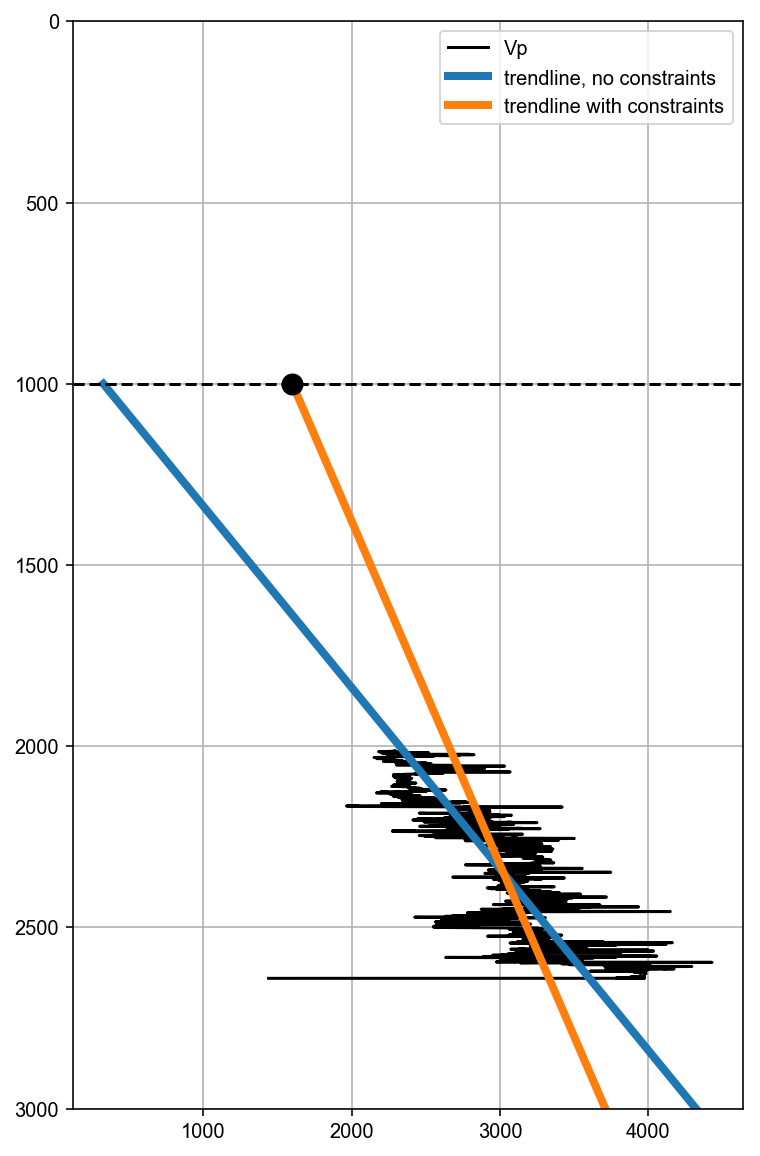

In [35]:
plt.figure(figsize=(6,10))
plt.plot(vp,z,'k',label='Vp')
plt.plot(trend,zfit,lw=4,label='trendline, no constraints')
plt.plot(fit1(zfit),zfit,lw=4,label='trendline with constraints')
plt.plot(vp0,z0,'ko',ms=10)
plt.ylim(3000,0)
plt.axhline(y=z0, color='k', ls='--')
plt.legend()
plt.grid()